In [1]:
import tensorflow as tf
from keras.layers import Input, Conv2D, Conv2DTranspose, MaxPooling2D, concatenate, Dropout
from keras.models import Model
from keras.optimizers import Adam
from keras.callbacks import ModelCheckpoint
import os
import cv2
import matplotlib.pyplot as plt
import numpy as np
from albumentations import RandomCrop, HorizontalFlip, VerticalFlip, RandomRotate90

2023-11-08 20:48:53.253580: E tensorflow/compiler/xla/stream_executor/cuda/cuda_dnn.cc:9342] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2023-11-08 20:48:53.253610: E tensorflow/compiler/xla/stream_executor/cuda/cuda_fft.cc:609] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2023-11-08 20:48:53.253637: E tensorflow/compiler/xla/stream_executor/cuda/cuda_blas.cc:1518] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2023-11-08 20:48:53.261516: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.


# Data Preparation

In [2]:
CONFIGURATION = {
    "N_FILTER":16,
    "IM_SIZE":256,
    "BATCH SIZE":32,
    "N_EPOCH":50,
    "SHUFFLE_SIZE":32
}

In [3]:
train_images_dir = './dataset/train_img/'
train_masks_dir = './dataset/train_mask/'
# train_mask_non_fire_path = 'None'

val_images_dir = './dataset/val_img/'
val_masks_dir = './dataset/val_mask/'

In [4]:
train_images_paths = []
train_masks_paths = []

val_images_paths = []
val_masks_paths = []

for i in os.listdir(train_images_dir):
    train_images_paths.append(train_images_dir+i)
    train_masks_paths.append(train_masks_dir+i)

for i in os.listdir(val_images_dir):
    val_images_paths.append(val_images_dir+i)
    val_masks_paths.append(val_masks_dir+i)

In [5]:
print(train_images_paths[0], train_masks_paths[0])
print(train_images_paths[-1], train_masks_paths[-1])

print(val_images_paths[0], val_masks_paths[0])
print(val_images_paths[-1], val_masks_paths[-1])

print(len(train_images_paths), len(train_masks_paths))
print(len(val_images_paths), len(val_masks_paths))

./dataset/train_img/water_body_1519.jpg ./dataset/train_mask/water_body_1519.jpg
./dataset/train_img/water_body_1763.jpg ./dataset/train_mask/water_body_1763.jpg
./dataset/val_img/water_body_18.jpg ./dataset/val_mask/water_body_18.jpg
./dataset/val_img/water_body_3.jpg ./dataset/val_mask/water_body_3.jpg
2821 2821
20 20


In [6]:
train_dataset = tf.data.Dataset.from_tensor_slices((train_images_paths, train_masks_paths))
val_dataset = tf.data.Dataset.from_tensor_slices((val_images_paths, val_masks_paths))

2023-11-08 20:48:58.247295: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:894] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2023-11-08 20:48:58.252240: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:894] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2023-11-08 20:48:58.252494: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:894] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysf

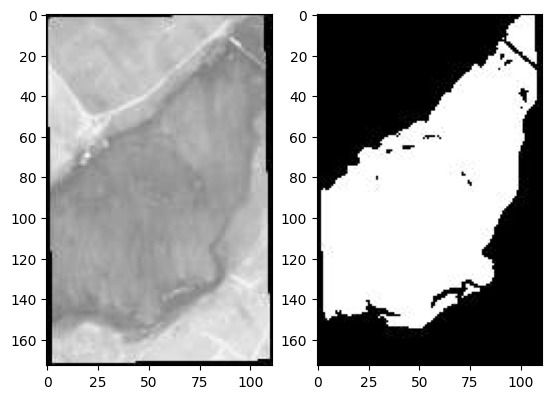

In [7]:
for i, j in train_dataset.take(1):
    # plt.figure(figsize=(12, 12))
    orig = cv2.imread(str(i.numpy())[2:-1])
    # print(orig.shape)
    orig = cv2.cvtColor(orig, cv2.COLOR_BGR2GRAY)
    plt.subplot(1, 2, 1)
    plt.imshow(orig, cmap='gray')
    mask = cv2.imread(str(j.numpy())[2:-1])
    # print(mask.shape)
    mask = cv2.cvtColor(mask, cv2.COLOR_BGR2GRAY)
    plt.subplot(1, 2, 2)
    plt.imshow(mask, cmap='gray')

In [8]:
def augmentation(orig, mask, random_crop=0.5, horizontal_flip=0.5, vertical_flip=0.5, random_rotate90=0.5):
    # print('1: ', np.max(orig), np.max(mask))
    aug = RandomCrop(height=192, width=192, p=random_crop)
    augment = aug(image=orig, mask = mask)
    new_orig = augment['image']
    new_mask = augment['mask']

    # print('2: ', np.max(new_orig), np.max(new_mask))
    aug = RandomRotate90(p=random_rotate90)
    augment = aug(image=new_orig, mask=new_mask)
    new_orig = augment['image']
    new_mask = augment['mask']


    # print('3: ', np.max(new_orig), np.max(new_mask))
    aug = HorizontalFlip(p=horizontal_flip)
    augment = aug(image=new_orig, mask=new_mask)
    new_orig = augment['image']
    new_mask = augment['mask']

    # print('4: ', np.max(new_orig), np.max(new_mask))
    aug = VerticalFlip(p=vertical_flip)
    augment = aug(image=new_orig, mask=new_mask)
    new_orig = augment['image']
    new_mask = augment['mask']
    # print('5: ', np.max(new_orig), np.max(new_mask))
    return new_orig, new_mask

In [9]:
def import_image(im_path, mask_path, aug=False):
    image = cv2.imread(str(im_path)[2:-1])
    image = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
    image = cv2.resize(image, (CONFIGURATION['IM_SIZE'], CONFIGURATION['IM_SIZE']))
    image = np.expand_dims(image, -1)
    image = image/255

    mask_image = cv2.imread(str(mask_path)[2:-1])
    mask_image = cv2.cvtColor(mask_image, cv2.COLOR_BGR2GRAY)
    mask_image = cv2.resize(mask_image, (CONFIGURATION['IM_SIZE'], CONFIGURATION['IM_SIZE']))
    mask_image = np.expand_dims(mask_image, -1)
    mask_image = mask_image/255

    if aug==True:
        image, mask_image = augmentation(image, mask_image)

        image = cv2.resize(image, (CONFIGURATION['IM_SIZE'], CONFIGURATION['IM_SIZE']))
        mask_image = cv2.resize(mask_image, (CONFIGURATION['IM_SIZE'], CONFIGURATION['IM_SIZE']))
        
        # print('im, mask', np.max(image), np.max(mask_image))
    return tf.convert_to_tensor(image, dtype=tf.float32), tf.convert_to_tensor(mask_image, dtype=tf.float32)

In [10]:
def cv_read(im_path, mask_path):
    img, mask = tf.numpy_function(import_image, inp=[im_path, mask_path, False], Tout=[tf.float32, tf.float32])
    img = tf.reshape(img, shape=(CONFIGURATION['IM_SIZE'], CONFIGURATION['IM_SIZE'], 1))
    mask = tf.reshape(mask, shape=(CONFIGURATION['IM_SIZE'], CONFIGURATION['IM_SIZE'], 1))
    return img, mask

In [11]:
def cv_read_aug(im_path, mask_path):
    img, mask = tf.numpy_function(import_image, inp=[im_path, mask_path, True], Tout=[tf.float32, tf.float32])
    img = tf.reshape(img, shape=(CONFIGURATION['IM_SIZE'], CONFIGURATION['IM_SIZE'], 1))
    mask = tf.reshape(mask, shape=(CONFIGURATION['IM_SIZE'], CONFIGURATION['IM_SIZE'], 1))
    return img, mask

In [12]:
val_dataset = val_dataset.map(cv_read)
train_dataset = train_dataset.map(cv_read_aug)

In [13]:
train_dataset

<_MapDataset element_spec=(TensorSpec(shape=(256, 256, 1), dtype=tf.float32, name=None), TensorSpec(shape=(256, 256, 1), dtype=tf.float32, name=None))>

In [14]:
for i, j in train_dataset.take(1):
    print(i.shape)

(256, 256, 1)


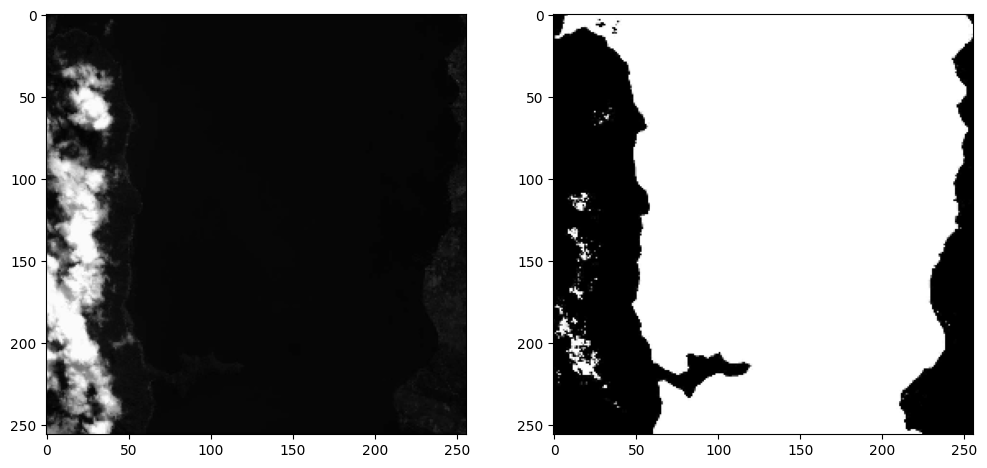

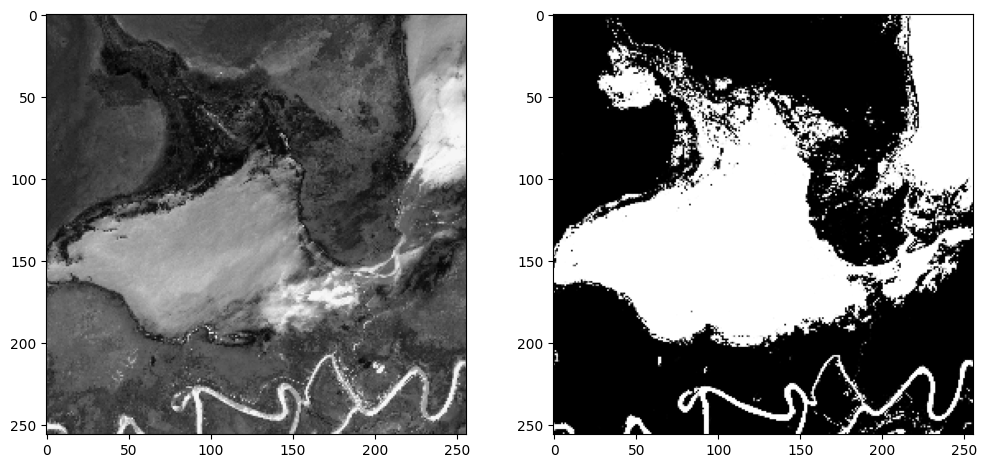

In [15]:
k = 1
for i, j in val_dataset.take(2):
    plt.figure(figsize=(12, 12))
    plt.subplot(2, 2, k)
    plt.imshow(i, cmap='grey')
    plt.subplot(2, 2, k+1)
    plt.imshow(j, cmap='grey')
    k+=2

In [16]:
train_dataset = (train_dataset
                 .batch(CONFIGURATION['BATCH SIZE'])
                 .shuffle(CONFIGURATION['SHUFFLE_SIZE'], reshuffle_each_iteration=True)
                 .prefetch(tf.data.AUTOTUNE))

In [17]:
val_dataset = (val_dataset
                 .batch(CONFIGURATION['BATCH SIZE'])
                #  .shuffle(128, reshuffle_each_iteration=False)
                 .prefetch(tf.data.AUTOTUNE))

In [18]:
train_dataset

<_PrefetchDataset element_spec=(TensorSpec(shape=(None, 256, 256, 1), dtype=tf.float32, name=None), TensorSpec(shape=(None, 256, 256, 1), dtype=tf.float32, name=None))>

In [19]:
def double_conv_block(x, n_filters):
    x = Conv2D(n_filters, (3, 3), padding='same', activation='relu', kernel_initializer='he_normal')(x)
    x = Conv2D(n_filters, (3, 3), padding='same', activation='relu', kernel_initializer='he_normal')(x)

    return x

In [20]:
def downSample_block(x, n_filters):
    conv_out = double_conv_block(x, n_filters)
    pool = MaxPooling2D(pool_size=(2, 2))(conv_out)
    drop = Dropout(0.25)(pool)

    return conv_out, drop

In [21]:
def upsample_block(x, conv_out, n_filters):
    x = Conv2DTranspose(n_filters, (3, 3), (2, 2), padding='same')(x)
    x = concatenate([x, conv_out])
    x = Dropout(0.3)(x)
    x = double_conv_block(x, n_filters)
    return x

In [22]:
input = Input(shape=(CONFIGURATION['IM_SIZE'], CONFIGURATION['IM_SIZE'], 1))

conv1, drop1 = downSample_block(input, CONFIGURATION['N_FILTER']*1)
conv2, drop2 = downSample_block(drop1, CONFIGURATION['N_FILTER']*2)
conv3, drop3 = downSample_block(drop2, CONFIGURATION['N_FILTER']*4)
conv4, drop4 = downSample_block(drop3, CONFIGURATION['N_FILTER']*8)

bottleneck = double_conv_block(drop4, CONFIGURATION['N_FILTER']*16)

uconv4 = upsample_block(bottleneck, conv4, CONFIGURATION['N_FILTER']*8)
uconv3 = upsample_block(uconv4, conv3, CONFIGURATION['N_FILTER']*4)
uconv2 = upsample_block(uconv3, conv2, CONFIGURATION['N_FILTER']*2)
uconv1 = upsample_block(uconv2, conv1, CONFIGURATION['N_FILTER']*1)

output = Conv2D(1, (1, 1), padding='same', activation='sigmoid')(uconv1)

model = Model(input, output)

model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_1 (InputLayer)        [(None, 256, 256, 1)]        0         []                            
                                                                                                  
 conv2d (Conv2D)             (None, 256, 256, 16)         160       ['input_1[0][0]']             
                                                                                                  
 conv2d_1 (Conv2D)           (None, 256, 256, 16)         2320      ['conv2d[0][0]']              
                                                                                                  
 max_pooling2d (MaxPooling2  (None, 128, 128, 16)         0         ['conv2d_1[0][0]']            
 D)                                                                                           

In [23]:
model.compile(
    optimizer=Adam(learning_rate=1e-4),
    loss = 'binary_crossentropy',
    metrics=['accuracy']
)

model_save = ModelCheckpoint('unet_water_body.keras', verbose=1, save_best_only=True, save_weights_only=True)

In [24]:
model.fit(train_dataset, validation_data=val_dataset, epochs=CONFIGURATION['N_EPOCH'], verbose=1, callbacks=[model_save])

Epoch 1/50


2023-11-08 20:49:17.585294: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:961] layout failed: INVALID_ARGUMENT: Size of values 0 does not match size of permutation 4 @ fanin shape inmodel/dropout/dropout/SelectV2-2-TransposeNHWCToNCHW-LayoutOptimizer
2023-11-08 20:49:27.953481: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:422] ShuffleDatasetV3:11: Filling up shuffle buffer (this may take a while): 24 of 32
2023-11-08 20:49:30.814569: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:452] Shuffle buffer filled.
2023-11-08 20:49:30.839901: I tensorflow/compiler/xla/stream_executor/cuda/cuda_dnn.cc:442] Loaded cuDNN version 8700
2023-11-08 20:49:34.684852: W tensorflow/tsl/framework/bfc_allocator.cc:296] Allocator (GPU_0_bfc) ran out of memory trying to allocate 1.54GiB with freed_by_count=0. The caller indicates that this is not a failure, but this may mean that there could be performance gains if more memory were available.
2023-11-08 20:49:34.765514: W tensorflow/t

89/89 [==============================] - ETA: 0s - loss: 0.6387 - accuracy: 0.5136
Epoch 1: val_loss improved from inf to 0.61966, saving model to unet_water_body.keras
89/89 [==============================] - 123s 1s/step - loss: 0.6387 - accuracy: 0.5136 - val_loss: 0.6197 - val_accuracy: 0.5273
Epoch 2/50


2023-11-08 20:51:28.806131: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:422] ShuffleDatasetV3:11: Filling up shuffle buffer (this may take a while): 22 of 32
2023-11-08 20:51:32.604306: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:452] Shuffle buffer filled.


89/89 [==============================] - ETA: 0s - loss: 0.6036 - accuracy: 0.5481
Epoch 2: val_loss improved from 0.61966 to 0.58823, saving model to unet_water_body.keras
89/89 [==============================] - 101s 979ms/step - loss: 0.6036 - accuracy: 0.5481 - val_loss: 0.5882 - val_accuracy: 0.5851
Epoch 3/50


2023-11-08 20:53:09.758639: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:422] ShuffleDatasetV3:11: Filling up shuffle buffer (this may take a while): 20 of 32
2023-11-08 20:53:14.943563: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:452] Shuffle buffer filled.


89/89 [==============================] - ETA: 0s - loss: 0.5623 - accuracy: 0.6088
Epoch 3: val_loss did not improve from 0.58823
89/89 [==============================] - 101s 959ms/step - loss: 0.5623 - accuracy: 0.6088 - val_loss: 0.5892 - val_accuracy: 0.6022
Epoch 4/50


2023-11-08 20:54:50.194103: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:422] ShuffleDatasetV3:11: Filling up shuffle buffer (this may take a while): 23 of 32
2023-11-08 20:54:53.625298: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:452] Shuffle buffer filled.


89/89 [==============================] - ETA: 0s - loss: 0.5085 - accuracy: 0.6444
Epoch 4: val_loss improved from 0.58823 to 0.54809, saving model to unet_water_body.keras
89/89 [==============================] - 96s 934ms/step - loss: 0.5085 - accuracy: 0.6444 - val_loss: 0.5481 - val_accuracy: 0.6143
Epoch 5/50


2023-11-08 20:56:26.575119: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:422] ShuffleDatasetV3:11: Filling up shuffle buffer (this may take a while): 23 of 32
2023-11-08 20:56:30.023093: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:452] Shuffle buffer filled.


89/89 [==============================] - ETA: 0s - loss: 0.4761 - accuracy: 0.6641
Epoch 5: val_loss improved from 0.54809 to 0.54617, saving model to unet_water_body.keras
89/89 [==============================] - 96s 925ms/step - loss: 0.4761 - accuracy: 0.6641 - val_loss: 0.5462 - val_accuracy: 0.6228
Epoch 6/50


2023-11-08 20:58:02.254793: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:422] ShuffleDatasetV3:11: Filling up shuffle buffer (this may take a while): 22 of 32
2023-11-08 20:58:05.888520: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:452] Shuffle buffer filled.


89/89 [==============================] - ETA: 0s - loss: 0.4659 - accuracy: 0.6685
Epoch 6: val_loss improved from 0.54617 to 0.54401, saving model to unet_water_body.keras
89/89 [==============================] - 95s 920ms/step - loss: 0.4659 - accuracy: 0.6685 - val_loss: 0.5440 - val_accuracy: 0.6286
Epoch 7/50


2023-11-08 20:59:37.614107: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:422] ShuffleDatasetV3:11: Filling up shuffle buffer (this may take a while): 24 of 32
2023-11-08 20:59:40.344085: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:452] Shuffle buffer filled.


89/89 [==============================] - ETA: 0s - loss: 0.4664 - accuracy: 0.6665
Epoch 7: val_loss improved from 0.54401 to 0.50425, saving model to unet_water_body.keras
89/89 [==============================] - 94s 917ms/step - loss: 0.4664 - accuracy: 0.6665 - val_loss: 0.5042 - val_accuracy: 0.6482
Epoch 8/50


2023-11-08 21:01:12.034223: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:422] ShuffleDatasetV3:11: Filling up shuffle buffer (this may take a while): 24 of 32
2023-11-08 21:01:14.811744: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:452] Shuffle buffer filled.


89/89 [==============================] - ETA: 0s - loss: 0.4411 - accuracy: 0.6821
Epoch 8: val_loss did not improve from 0.50425
89/89 [==============================] - 95s 918ms/step - loss: 0.4411 - accuracy: 0.6821 - val_loss: 0.5411 - val_accuracy: 0.6353
Epoch 9/50


2023-11-08 21:02:46.497086: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:422] ShuffleDatasetV3:11: Filling up shuffle buffer (this may take a while): 24 of 32
2023-11-08 21:02:49.175798: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:452] Shuffle buffer filled.


89/89 [==============================] - ETA: 0s - loss: 0.4325 - accuracy: 0.6846
Epoch 9: val_loss improved from 0.50425 to 0.50159, saving model to unet_water_body.keras
89/89 [==============================] - 95s 928ms/step - loss: 0.4325 - accuracy: 0.6846 - val_loss: 0.5016 - val_accuracy: 0.6547
Epoch 10/50


2023-11-08 21:04:21.627118: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:422] ShuffleDatasetV3:11: Filling up shuffle buffer (this may take a while): 24 of 32
2023-11-08 21:04:24.384463: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:452] Shuffle buffer filled.


89/89 [==============================] - ETA: 0s - loss: 0.4298 - accuracy: 0.6833
Epoch 10: val_loss did not improve from 0.50159
89/89 [==============================] - 94s 916ms/step - loss: 0.4298 - accuracy: 0.6833 - val_loss: 0.5345 - val_accuracy: 0.6453
Epoch 11/50


2023-11-08 21:05:56.018427: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:422] ShuffleDatasetV3:11: Filling up shuffle buffer (this may take a while): 24 of 32
2023-11-08 21:05:58.771354: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:452] Shuffle buffer filled.


89/89 [==============================] - ETA: 0s - loss: 0.4159 - accuracy: 0.6909
Epoch 11: val_loss did not improve from 0.50159
89/89 [==============================] - 95s 923ms/step - loss: 0.4159 - accuracy: 0.6909 - val_loss: 0.5684 - val_accuracy: 0.6190
Epoch 12/50


2023-11-08 21:07:30.776360: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:422] ShuffleDatasetV3:11: Filling up shuffle buffer (this may take a while): 24 of 32
2023-11-08 21:07:33.550444: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:452] Shuffle buffer filled.


89/89 [==============================] - ETA: 0s - loss: 0.4095 - accuracy: 0.6944
Epoch 12: val_loss did not improve from 0.50159
89/89 [==============================] - 94s 916ms/step - loss: 0.4095 - accuracy: 0.6944 - val_loss: 0.5673 - val_accuracy: 0.6212
Epoch 13/50


2023-11-08 21:09:05.130324: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:422] ShuffleDatasetV3:11: Filling up shuffle buffer (this may take a while): 24 of 32
2023-11-08 21:09:07.887992: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:452] Shuffle buffer filled.


89/89 [==============================] - ETA: 0s - loss: 0.4173 - accuracy: 0.6905
Epoch 13: val_loss did not improve from 0.50159
89/89 [==============================] - 95s 921ms/step - loss: 0.4173 - accuracy: 0.6905 - val_loss: 0.5620 - val_accuracy: 0.6236
Epoch 14/50


2023-11-08 21:10:39.698843: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:422] ShuffleDatasetV3:11: Filling up shuffle buffer (this may take a while): 23 of 32
2023-11-08 21:10:42.901448: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:452] Shuffle buffer filled.


89/89 [==============================] - ETA: 0s - loss: 0.4089 - accuracy: 0.6936
Epoch 14: val_loss did not improve from 0.50159
89/89 [==============================] - 95s 927ms/step - loss: 0.4089 - accuracy: 0.6936 - val_loss: 0.5146 - val_accuracy: 0.6431
Epoch 15/50


2023-11-08 21:12:15.354802: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:422] ShuffleDatasetV3:11: Filling up shuffle buffer (this may take a while): 24 of 32
2023-11-08 21:12:18.169934: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:452] Shuffle buffer filled.


89/89 [==============================] - ETA: 0s - loss: 0.4043 - accuracy: 0.6943
Epoch 15: val_loss did not improve from 0.50159
89/89 [==============================] - 94s 916ms/step - loss: 0.4043 - accuracy: 0.6943 - val_loss: 0.5247 - val_accuracy: 0.6361
Epoch 16/50


2023-11-08 21:13:49.726748: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:422] ShuffleDatasetV3:11: Filling up shuffle buffer (this may take a while): 24 of 32
2023-11-08 21:13:52.475792: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:452] Shuffle buffer filled.


89/89 [==============================] - ETA: 0s - loss: 0.3964 - accuracy: 0.6983
Epoch 16: val_loss did not improve from 0.50159
89/89 [==============================] - 95s 929ms/step - loss: 0.3964 - accuracy: 0.6983 - val_loss: 0.5526 - val_accuracy: 0.6247
Epoch 17/50


2023-11-08 21:15:25.127062: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:422] ShuffleDatasetV3:11: Filling up shuffle buffer (this may take a while): 23 of 32
2023-11-08 21:15:28.525485: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:452] Shuffle buffer filled.


89/89 [==============================] - ETA: 0s - loss: 0.3957 - accuracy: 0.6993
Epoch 17: val_loss did not improve from 0.50159
89/89 [==============================] - 97s 939ms/step - loss: 0.3957 - accuracy: 0.6993 - val_loss: 0.5268 - val_accuracy: 0.6351
Epoch 18/50


2023-11-08 21:17:01.847687: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:422] ShuffleDatasetV3:11: Filling up shuffle buffer (this may take a while): 22 of 32
2023-11-08 21:17:05.415786: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:452] Shuffle buffer filled.


89/89 [==============================] - ETA: 0s - loss: 0.3897 - accuracy: 0.6991
Epoch 18: val_loss did not improve from 0.50159
89/89 [==============================] - 97s 939ms/step - loss: 0.3897 - accuracy: 0.6991 - val_loss: 0.5691 - val_accuracy: 0.6338
Epoch 19/50


2023-11-08 21:18:38.824631: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:422] ShuffleDatasetV3:11: Filling up shuffle buffer (this may take a while): 23 of 32
2023-11-08 21:18:42.274279: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:452] Shuffle buffer filled.


89/89 [==============================] - ETA: 0s - loss: 0.3879 - accuracy: 0.7026
Epoch 19: val_loss did not improve from 0.50159
89/89 [==============================] - 97s 939ms/step - loss: 0.3879 - accuracy: 0.7026 - val_loss: 0.5109 - val_accuracy: 0.6450
Epoch 20/50


2023-11-08 21:20:15.779612: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:422] ShuffleDatasetV3:11: Filling up shuffle buffer (this may take a while): 22 of 32
2023-11-08 21:20:19.465123: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:452] Shuffle buffer filled.


89/89 [==============================] - ETA: 0s - loss: 0.3871 - accuracy: 0.7007
Epoch 20: val_loss did not improve from 0.50159
89/89 [==============================] - 98s 943ms/step - loss: 0.3871 - accuracy: 0.7007 - val_loss: 0.5216 - val_accuracy: 0.6376
Epoch 21/50


2023-11-08 21:21:53.277052: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:422] ShuffleDatasetV3:11: Filling up shuffle buffer (this may take a while): 23 of 32
2023-11-08 21:21:56.475827: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:452] Shuffle buffer filled.


89/89 [==============================] - ETA: 0s - loss: 0.3836 - accuracy: 0.7045
Epoch 21: val_loss improved from 0.50159 to 0.49421, saving model to unet_water_body.keras
89/89 [==============================] - 95s 924ms/step - loss: 0.3836 - accuracy: 0.7045 - val_loss: 0.4942 - val_accuracy: 0.6508
Epoch 22/50


2023-11-08 21:23:28.773269: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:422] ShuffleDatasetV3:11: Filling up shuffle buffer (this may take a while): 21 of 32
2023-11-08 21:23:33.082259: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:452] Shuffle buffer filled.


89/89 [==============================] - ETA: 0s - loss: 0.3825 - accuracy: 0.7046
Epoch 22: val_loss did not improve from 0.49421
89/89 [==============================] - 99s 955ms/step - loss: 0.3825 - accuracy: 0.7046 - val_loss: 0.5187 - val_accuracy: 0.6402
Epoch 23/50


2023-11-08 21:25:08.077596: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:422] ShuffleDatasetV3:11: Filling up shuffle buffer (this may take a while): 17 of 32
2023-11-08 21:25:14.899192: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:452] Shuffle buffer filled.


89/89 [==============================] - ETA: 0s - loss: 0.3736 - accuracy: 0.7072
Epoch 23: val_loss did not improve from 0.49421
89/89 [==============================] - 101s 942ms/step - loss: 0.3736 - accuracy: 0.7072 - val_loss: 0.5394 - val_accuracy: 0.6384
Epoch 24/50


2023-11-08 21:26:48.830109: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:422] ShuffleDatasetV3:11: Filling up shuffle buffer (this may take a while): 24 of 32
2023-11-08 21:26:51.674339: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:452] Shuffle buffer filled.


89/89 [==============================] - ETA: 0s - loss: 0.3716 - accuracy: 0.7064
Epoch 24: val_loss did not improve from 0.49421
89/89 [==============================] - 98s 955ms/step - loss: 0.3716 - accuracy: 0.7064 - val_loss: 0.5027 - val_accuracy: 0.6494
Epoch 25/50


2023-11-08 21:28:26.441036: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:422] ShuffleDatasetV3:11: Filling up shuffle buffer (this may take a while): 22 of 32
2023-11-08 21:28:30.830910: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:452] Shuffle buffer filled.


89/89 [==============================] - ETA: 0s - loss: 0.3702 - accuracy: 0.7081
Epoch 25: val_loss did not improve from 0.49421
89/89 [==============================] - 99s 952ms/step - loss: 0.3702 - accuracy: 0.7081 - val_loss: 0.5352 - val_accuracy: 0.6388
Epoch 26/50


2023-11-08 21:30:05.786046: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:422] ShuffleDatasetV3:11: Filling up shuffle buffer (this may take a while): 22 of 32
2023-11-08 21:30:09.856138: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:452] Shuffle buffer filled.


89/89 [==============================] - ETA: 0s - loss: 0.3723 - accuracy: 0.7057
Epoch 26: val_loss improved from 0.49421 to 0.49247, saving model to unet_water_body.keras
89/89 [==============================] - 98s 935ms/step - loss: 0.3723 - accuracy: 0.7057 - val_loss: 0.4925 - val_accuracy: 0.6448
Epoch 27/50


2023-11-08 21:31:42.912316: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:422] ShuffleDatasetV3:11: Filling up shuffle buffer (this may take a while): 21 of 32
2023-11-08 21:31:47.536228: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:452] Shuffle buffer filled.


89/89 [==============================] - ETA: 0s - loss: 0.3673 - accuracy: 0.7068
Epoch 27: val_loss improved from 0.49247 to 0.48208, saving model to unet_water_body.keras
89/89 [==============================] - 97s 926ms/step - loss: 0.3673 - accuracy: 0.7068 - val_loss: 0.4821 - val_accuracy: 0.6539
Epoch 28/50


2023-11-08 21:33:20.045904: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:422] ShuffleDatasetV3:11: Filling up shuffle buffer (this may take a while): 18 of 32
2023-11-08 21:33:27.518960: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:452] Shuffle buffer filled.


89/89 [==============================] - ETA: 0s - loss: 0.3637 - accuracy: 0.7097
Epoch 28: val_loss did not improve from 0.48208
89/89 [==============================] - 100s 929ms/step - loss: 0.3637 - accuracy: 0.7097 - val_loss: 0.4974 - val_accuracy: 0.6433
Epoch 29/50


2023-11-08 21:35:00.304524: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:422] ShuffleDatasetV3:11: Filling up shuffle buffer (this may take a while): 22 of 32
2023-11-08 21:35:03.953464: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:452] Shuffle buffer filled.


89/89 [==============================] - ETA: 0s - loss: 0.3680 - accuracy: 0.7087
Epoch 29: val_loss did not improve from 0.48208
89/89 [==============================] - 96s 927ms/step - loss: 0.3680 - accuracy: 0.7087 - val_loss: 0.5337 - val_accuracy: 0.6393
Epoch 30/50


2023-11-08 21:36:36.274318: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:422] ShuffleDatasetV3:11: Filling up shuffle buffer (this may take a while): 19 of 32
2023-11-08 21:36:41.470066: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:452] Shuffle buffer filled.


89/89 [==============================] - ETA: 0s - loss: 0.3662 - accuracy: 0.7082
Epoch 30: val_loss did not improve from 0.48208
89/89 [==============================] - 96s 911ms/step - loss: 0.3662 - accuracy: 0.7082 - val_loss: 0.5447 - val_accuracy: 0.6341
Epoch 31/50


2023-11-08 21:38:12.276462: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:422] ShuffleDatasetV3:11: Filling up shuffle buffer (this may take a while): 22 of 32
2023-11-08 21:38:15.885568: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:452] Shuffle buffer filled.


89/89 [==============================] - ETA: 0s - loss: 0.3622 - accuracy: 0.7111
Epoch 31: val_loss improved from 0.48208 to 0.46631, saving model to unet_water_body.keras
89/89 [==============================] - 98s 949ms/step - loss: 0.3622 - accuracy: 0.7111 - val_loss: 0.4663 - val_accuracy: 0.6619
Epoch 32/50


2023-11-08 21:39:50.153749: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:422] ShuffleDatasetV3:11: Filling up shuffle buffer (this may take a while): 21 of 32
2023-11-08 21:39:54.371990: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:452] Shuffle buffer filled.


89/89 [==============================] - ETA: 0s - loss: 0.3567 - accuracy: 0.7118
Epoch 32: val_loss did not improve from 0.46631
89/89 [==============================] - 99s 955ms/step - loss: 0.3567 - accuracy: 0.7118 - val_loss: 0.4904 - val_accuracy: 0.6499
Epoch 33/50


2023-11-08 21:41:29.408934: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:422] ShuffleDatasetV3:11: Filling up shuffle buffer (this may take a while): 22 of 32
2023-11-08 21:41:33.449123: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:452] Shuffle buffer filled.


89/89 [==============================] - ETA: 0s - loss: 0.3581 - accuracy: 0.7105
Epoch 33: val_loss improved from 0.46631 to 0.45515, saving model to unet_water_body.keras
89/89 [==============================] - 98s 940ms/step - loss: 0.3581 - accuracy: 0.7105 - val_loss: 0.4552 - val_accuracy: 0.6649
Epoch 34/50


2023-11-08 21:43:06.978964: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:422] ShuffleDatasetV3:11: Filling up shuffle buffer (this may take a while): 10 of 32
2023-11-08 21:43:17.511986: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:452] Shuffle buffer filled.


 8/89 [=>............................] - ETA: 1:35 - loss: 0.3603 - accuracy: 0.7131

KeyboardInterrupt: 

# Testing

In [55]:
model.load_weights('./unet_model.keras')

In [59]:
image = cv2.imread('./dataset/train_img/water_body_100.jpg')
image = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
image = cv2.resize(image, (CONFIGURATION['IM_SIZE'], CONFIGURATION['IM_SIZE']))
image = np.expand_dims(image, -1)/255

image = np.expand_dims(image, axis=0)

res = model.predict(image)

1/1 [==============================] - 0s 25ms/step


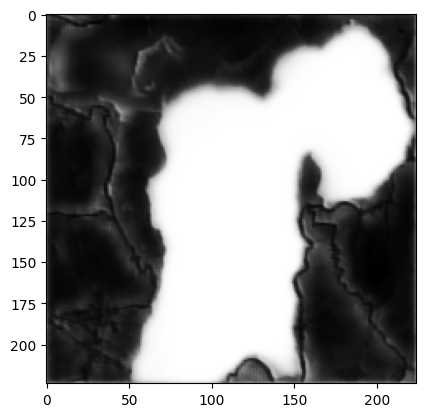

In [60]:
plt.imshow(res[0], cmap='gray')

In [61]:
for i in os.listdir(val_images_dir):
    img_path = val_images_dir+i
    image = cv2.imread(img_path)
    image = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
    image = cv2.resize(image, (CONFIGURATION['IM_SIZE'], CONFIGURATION['IM_SIZE']))
    image = np.expand_dims(image, -1)/255

    image = np.expand_dims(image, axis=0)
    # print(image.shape)

    res = model.predict(image)

    pred_img = res[0]*255

    cv2.imwrite(val_images_dir + i[:-4] + '_pred.jpg', pred_img)

1/1 [==============================] - 0s 18ms/step
